# Naive Forecast

In [1]:
%load_ext autoreload
%autoreload 2

## Install `tfutils`

In [2]:
!pip install -e /content/drive/MyDrive/projects/tfutils

Obtaining file:///content/drive/MyDrive/projects/tfutils
  Running setup.py develop for tfutils


## Some imports

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

## Some helper functions

In [14]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

## Make a dummy time series

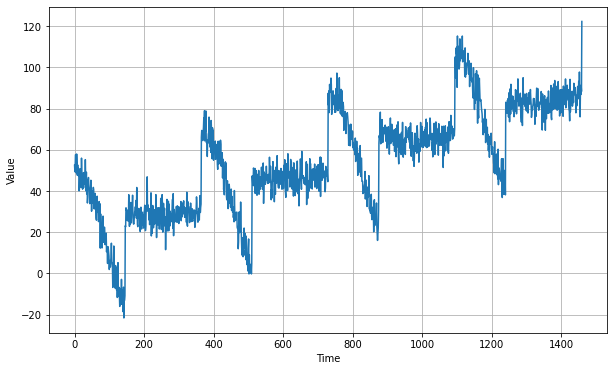

In [15]:
time = np.arange(4* 365 + 1, dtype='float32')
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, 
                                                     amplitude=amplitude)
series += noise(time, noise_level, seed=42)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

## Train Test Split

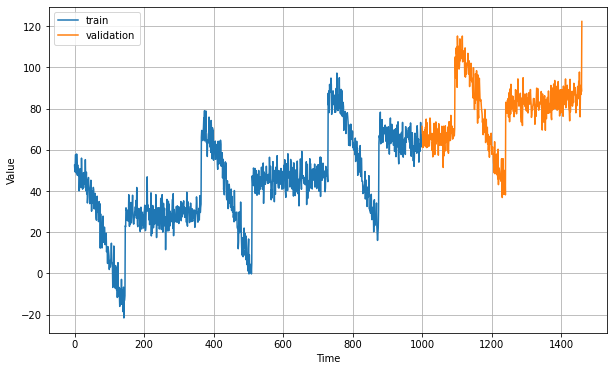

In [18]:
split_time = 1000

time_train = time[:split_time]
x_train = series[:split_time]

time_valid = time[split_time:]
x_valid = series[split_time:]

plt.figure(figsize=(10, 6))
plot_series(time_train, x_train, label='train')
plot_series(time_valid, x_valid, label='validation')
plt.legend()

## Naive Forecast

$\hat{y_{t}} = y_{t-1}$

In [30]:
naive_forecast = series[split_time:-1]

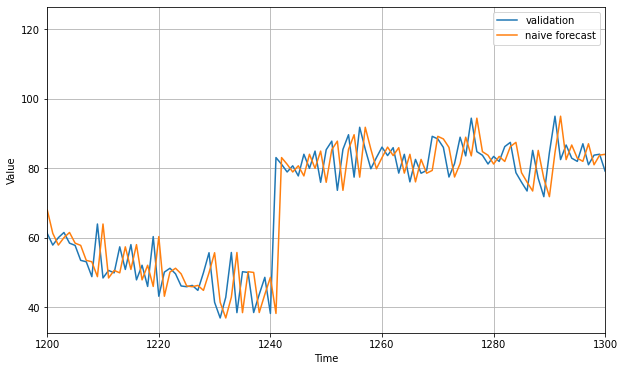

In [31]:
plt.figure(figsize=(10, 6))
plot_series(time_valid[1:], x_valid[1:], label='validation')
plot_series(time_valid[1:], naive_forecast, label='naive forecast')
plt.xlim(1200, 1300)
plt.legend();

In [33]:
tf.keras.metrics.mean_squared_error(x_valid[1:], naive_forecast).numpy()

61.924538

## Moving Average Forecast

* Forecast the next value as the mean of last few values in the window.
* if the window = 1, then it is equivalent to the naive forecast.

In [47]:
series

array([ 52.48357 ,  49.35275 ,  53.314735, ...,  91.37325 ,  88.32383 ,
       122.30772 ], dtype=float32)

In [52]:
def moving_average_forecast(series, window_size):
    n = len(series)
    forecasts = np.zeros(shape=n)

    for t in range(window_size, n):
        forecasts[t] = np.mean(series[(t-window_size):t])

    return forecasts[window_size:]

In [54]:
(moving_average_forecast(x_valid, 1) == naive_forecast).all()

True

In [57]:
window_size = 30
mov_avg_forecast = moving_average_forecast(x_valid, window_size)

In [58]:
print(tf.keras.metrics.mean_squared_error(x_valid[window_size:], mov_avg_forecast))

tf.Tensor(112.52480085613446, shape=(), dtype=float64)


* This is arguably worse than the naive forecast. The naive forecast is very hard to beat
* **Note**: Naive forecast is only a day-one ahead forecast. If we forecast ahead with it it will just be a constant line.

The moving average model does not anticipate trend or seasonlity. We can remove these components by differencing the time series.

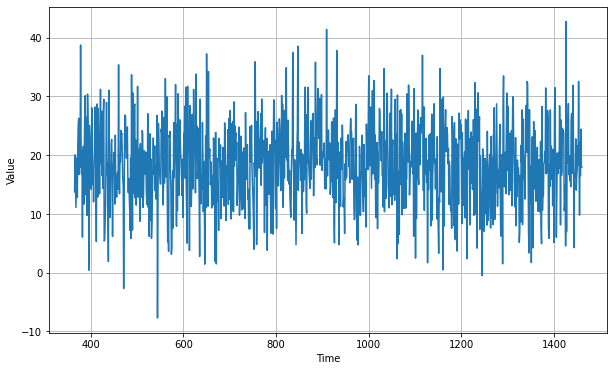

In [59]:
diff_series = series[365:] - series[:-365]
diff_time = time[365:]

plt.figure(figsize=(10, 6))
plot_series(diff_time, diff_series)
plt.show()

The trend and seasonlity seems to have gone!

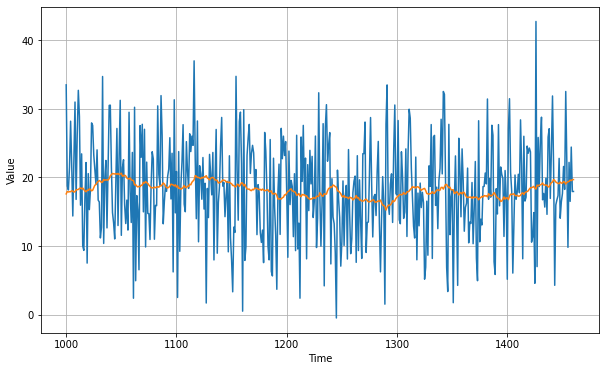

In [61]:
diff_mov_avg = moving_average_forecast(diff_series, 50)[split_time-365-50:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, diff_series[split_time-365:])
plot_series(time_valid, diff_mov_avg)
plt.show()

Now let's add back the trend and the seasonality to the data

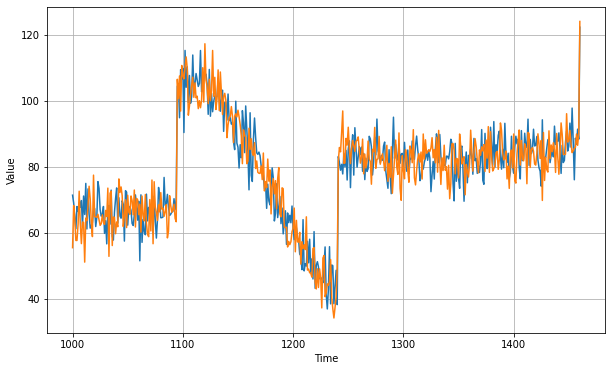

In [64]:
diff_mov_avg_plus_past = series[split_time - 365:-365] + diff_mov_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_mov_avg_plus_past)
plt.show()

In [67]:
print(tf.keras.metrics.mean_squared_error(x_valid, diff_mov_avg_plus_past).numpy())

52.973661273331764


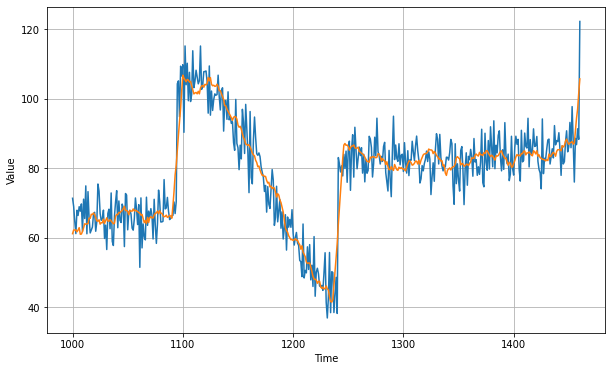

In [72]:
diff_mov_avg_plus_smooth_past = moving_average_forecast(series[split_time - 370:-360], 10) + diff_mov_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_mov_avg_plus_smooth_past)
plt.show()

In [74]:
print(tf.keras.metrics.mean_squared_error(x_valid, diff_mov_avg_plus_smooth_past).numpy())

33.45226250744172
